In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("ggplot")
pd.set_option("display.max_columns",300)
from pandas.tools.plotting import scatter_matrix
from scipy import stats

from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline, NaturalCubicSpline) 

from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)

from regression_tools.plotting_tools import (
    plot_univariate_smooth,
    bootstrap_train,
    display_coef,
    plot_bootstrap_coefs,
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV


# Questions

1. Can I predict income inequality in a county (measured by difference between top income quintile and bottom income quintile) based on factors like:
    - Educational attainment
    - Proportion of population major ethnic groups
    - Population density
    - Birth rate
    - Target - diff between lowest and highest quintile* https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=bkmk
        - this will be positive, bounded by zero. 
        - likely NA's for some low-pop counties
2. Do counties in population-dense states have meaningfully different income inequality vs low-density states? 

# Data Cleaning and Aggregation

## Source data notes

- All data came from US Census Bureau FactFinder website factfinder.census.gov
- Education
    - Proportion of people in each county who have reached the label as their highest level of educational attainment.
    - Only includes people 25 or older as that seems to be the standard way the census measures a population's educational attainment. Educational attainment - only 
- Racial demographics
    - Represent the proportion of people in each county who identify with a particular racial group
    - Race data only described people who identify as a single race, so it does not include everyone in the population.
- Population density
- Birth rate - #births/# of people in county
- Income 
    - provided in means of quintiles + mean of top 5% within each county
    - **Target: diff between top 5% and lowest quintile**
        - this will be positive, bounded by zero. 
        - likely NA's for some low-pop counties

In [2]:
def remove_columns(df, keyword):
    for column_name in df.columns:
        if keyword in column_name:
            df.drop(column_name, axis=1, inplace=True)
    return df

def update_column_names(df, phrase_to_remove, phrase_to_append=''):
    column_list = []
    for column_name in df.columns:
        if phrase_to_remove in column_name:
            column_name = column_name.replace(phrase_to_remove,'') + ' ' + phrase_to_append
        column_list.append(column_name.strip())
    df.columns = column_list
    return df

def add_pct_columns(df, column_names_to_pct, denom_column_name):
    for column_name in column_names_to_pct:
        df[column_name+'%'] = df[column_name]/df[denom_column_name]
    return df

def convert_to_pct_columns(df, column_names_to_pct, denom_column_name):
    for column_name in column_names_to_pct:
        df[column_name] = df[column_name]/df[denom_column_name]
    return df

In [3]:
''' Quintiles prep

Table is grouped by county with income means for 5 quintiles and mean for top 5%

Get data from here https://factfinder.census.gov/faces/tableservices
B19081	MEAN HOUSEHOLD INCOME OF QUINTILES
Universe: Households
Geography: All counties in US
2011-2015 American Community Survey 5-Year Estimate
'''

quintiles = pd.read_csv('data/ACS_15_5YR_B19081_with_ann.csv', header=1, encoding = "ISO-8859-1")

# drop redundant ID column
quintiles.drop('Id', axis=1, inplace=True)
# remove error columns
quintiles = remove_columns(quintiles,'Error')
# update column names to remove redundant header elements
quintiles = update_column_names(quintiles, 'Estimate; Quintile Means: - ','Mean')
# rename county columns to be consistent with other tables, rename top 5 mean to be consistent with other columns
quintiles.rename(columns={'Id2':'County_Code','Geography':'County_State','Estimate; Top 5 Percent':'Top 5% Mean' }\
                 , inplace=True)

# create income disparity column
quintiles['Diff HighestQ-LowestQ'] = quintiles['Highest Quintile Mean']\
                                    - quintiles['Lowest Quintile Mean']
quintiles['Diff Top5%-LowestQ'] = quintiles['Top 5% Mean']\
                                    - quintiles['Lowest Quintile Mean']


''' Birth Rate Prep '''

# Get data from data folder provided. Reduce to only the columns we care about
pop_estimates = pd.read_csv('data/co-est2015-alldata-utf8-3142.csv')
birth_rate = pop_estimates.loc[:,['STATE','COUNTY','STNAME','CTYNAME','POPESTIMATE2015','BIRTHS2015','RBIRTH2015']]
birth_rate.columns = ['State', 'County_Code_drop', 'State_Name', 'County_Name', 'Pop_2015', 'Births_2015',\
                      'Birth_Rate_2015']
# Create new numeric column for county code with state + 000 county to enable merging with other dataframes
birth_rate['County_Code_drop']= birth_rate['County_Code_drop'].astype(str,'000').apply(lambda x: '{0:0>3}'.format(x))
birth_rate['County_Code'] = (birth_rate['State'].astype(str) + birth_rate['County_Code_drop']).astype(int)
birth_rate.drop('County_Code_drop', axis=1, inplace=True)


''' Population density prep '''

master = pd.read_csv('data/2015_master_sd_rnd_nan_to_min.csv')
master.rename(columns={'geo_id':'County_Code'}, inplace=True)
pop_density = master.loc[:,['County_Code','pop_den_2015']]    
    
''' Education prep

Table is grouped by county with county population and # of adults in each bucket

Get data from here https://factfinder.census.gov/faces/tableservices
S1501	EDUCATIONAL ATTAINMENT  more information
2011-2015 American Community Survey 5-Year Estimates
ONLY include education rates for adults 25 years and up because this seems to be 
the census standard for assessing the population education rate at large '''

# import data
education_25yr = pd.read_csv('data/ACS_15_5YR_S1501_with_ann.csv', header=1, encoding = "ISO-8859-1")
# drop redundant ID column
education_25yr.drop('Id', axis=1, inplace=True)
# remove error columns
education_25yr = remove_columns(education_25yr,'Error')
# update column names to remove redundant header elements
education_25yr = update_column_names(education_25yr, 'Total; Estimate; Population 25 years and over - ')
# rename county columns to be consistent with other tables
education_25yr.rename(columns={'Id2':'County_Code','Geography':'County_State',\
                               'Total; Estimate; Population 25 years and over':'Pop_25_years_and_over'}, \
                      inplace=True)

# change columns for rate
education_25yr = convert_to_pct_columns(education_25yr, ['Less than 9th grade',
       '9th to 12th grade, no diploma',
       'High school graduate (includes equivalency)',
       'Some college, no degree', "Associate's degree", "Bachelor's degree",
       'Graduate or professional degree'], 'Pop_25_years_and_over')


''' Racial Groups Prep

DP05	ACS DEMOGRAPHIC AND HOUSING ESTIMATES  more information
2011-2015 American Community Survey Selected Population Tables
limitation is only includes information for people who identify as a single race.

'''

# import data
race = pd.read_csv('data/ACS_15_SPT_DP05_with_ann.csv', header=1, encoding = "ISO-8859-1")

# rename county columns to be consistent with other tables
race.rename(columns={'Id2':'County_Code','Geography':'County_State'}, inplace=True)
race['County_Code'].unique().shape
# Create pivot table to make race column headers
race_pivot = pd.pivot_table(race, index= ['County_Code','County_State'],\
                            values = 'Estimate; SEX AND AGE - Total population', \
                            columns = 'Population Group', aggfunc='sum')
race_pivot.fillna(value=0, inplace=True)
race_pivot = pd.DataFrame(race_pivot.to_records())

# Turn race variables into percentages
race_pivot['Single_Race_Population']=race_pivot.iloc[:,2:].sum(axis=1)
race_pivot.columns = ['County_Code', 'County_State',
       'American Indian/Alaska Native',
       'Asian', 'Black/African American',
       'Native Hawaiian/Pacific Islander',
       'Other', 'White', 'Single_Race_Population']

race_pivot = convert_to_pct_columns(race_pivot, ['American Indian/Alaska Native','Asian', \
                                                 'Black/African American', 'Native Hawaiian/Pacific Islander',\
                                                 'Other', 'White'],'Single_Race_Population')
                
# race_pivot.head()
# quintiles.tail()
# birth_rate.head()
# pop_density.head()
# education_25yr.head().round(2)

In [4]:
'''Merge data then select for just predictors that we care about'''

merged_data = quintiles.merge(birth_rate, on='County_Code')
merged_data = merged_data.merge(race_pivot, on=['County_Code','County_State'])
merged_data = merged_data.merge(pop_density, on='County_Code')
merged_data = merged_data.merge(education_25yr, on=['County_Code','County_State'])
predictors_target = merged_data.loc[:, ['County_Code', 'County_Name','State_Name',\
                                        'Diff Top5%-LowestQ','Birth_Rate_2015', 'American Indian/Alaska Native',\
                                        'Asian','Black/African American', 'Native Hawaiian/Pacific Islander',\
                                        'Other','White', 'pop_den_2015','Less than 9th grade',\
                                        '9th to 12th grade, no diploma',\
                                        'High school graduate (includes equivalency)',
                                        'Some college, no degree', "Associate's degree", "Bachelor's degree",\
                                        'Graduate or professional degree']]
predictors_target.head()

County_Code     County_Name State_Name  Diff Top5%-LowestQ  \
0         1001  Autauga County    Alabama              227339   
1         1003  Baldwin County    Alabama              272508   
2         1005  Barbour County    Alabama              159870   
3         1007     Bibb County    Alabama              209597   
4         1009   Blount County    Alabama              167062   

   Birth_Rate_2015  American Indian/Alaska Native     Asian  \
0        10.846281                       0.000000  0.000000   
1        11.104997                       0.006082  0.006817   
2        10.093051                       0.000000  0.000000   
3        11.211557                       0.000000  0.000000   
4        10.456859                       0.000000  0.000000   

   Black/African American  Native Hawaiian/Pacific Islander     Other  \
0                0.194417                               0.0  0.000000   
1                0.097719                               0.0  0.009754   
2                0.479280                               0.0  0.035313   
3                0.218554                               0.0  0.000000   
4                0.015852                               0.0  0.000000   

      White  pop_den_2015  Less than 9th grade  9th to 12th grade, no diploma  \
0  0.805583     93.107956             0.038382                       0.089815   
1  0.879629    128.134341             0.032007                       0.072810   
2  0.485407     29.935234             0.092088                       0.174872   
3  0.781446     36.273075             0.069486                       0.124000   
4  0.984148     89.442267             0.069656                       0.145326   

   High school graduate (includes equivalency)  Some college, no degree  \
0                                     0.335417                 0.225860   
1                                     0.287815                 0.226860   
2                                     0.345066                 0.191036   
3                                     0.420628                 0.218376   
4                                     0.334424                 0.223990   

   Associate's degree  Bachelor's degree  Graduate or professional degree  
0            0.078224           0.134833                         0.097470  
1            0.090656           0.192612                         0.097240  
2            0.071778           0.075074                         0.050085  
3            0.061040           0.060529                         0.045940  
4            0.097696           0.086175                         0.042732

# Exploratory Data Analysis

## Target Investigation
- Looked at two potential measures for income gap:
        1. Top quintile - Bottom quintile
        2. Top 5% - Bottom 5%
  I chose the latter because the larger spread appeared to contain more information.
  
  
- The income gap has some large outliers, which makes the distribution of income gaps non-normal.
    - I took the log of the income gap to make the distribution more normal.
    - This worked so I chose to use the log of income gap as the target for my models.

/home/alex/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  exec(code_obj, self.user_global_ns, self.user_ns)


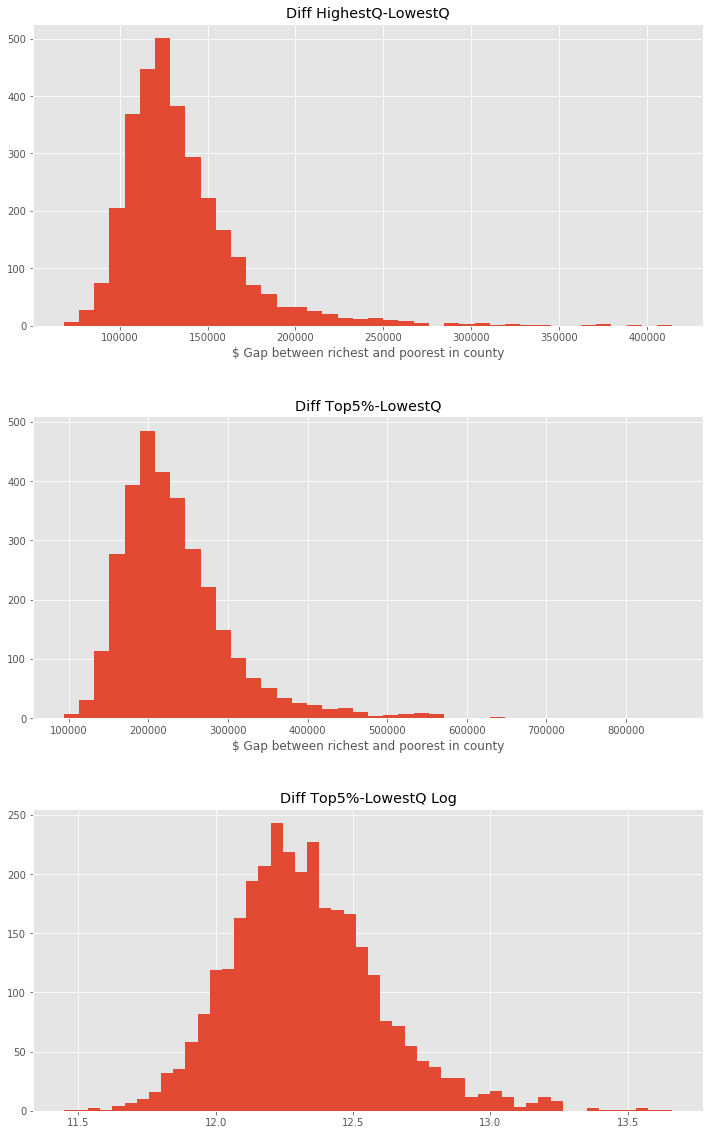

In [5]:
fig,(ax1,ax2,ax3) = plt.subplots(3,figsize=(12,20))
# visualization
quintiles.hist(column = ['Diff HighestQ-LowestQ','Diff Top5%-LowestQ'], \
               bins= 40, sharex=True, figsize=(10,4), ax=(ax1,ax2));
ax1.set_xlabel('$ Gap between richest and poorest in county')
ax2.set_xlabel('$ Gap between richest and poorest in county')

#log transform quintiles
quintiles['Diff Top5%-LowestQ'].apply(np.log).hist(bins=50, ax=ax3)
ax3.set_title('Diff Top5%-LowestQ Log');


## Population Density Histograms

- The population density histogram has some strong outliers on the high end, which make the original plot fairly uninformative. 
    - As you might expect, thelargest outliers are mostly in New York City
- To get a better look at the values that are not massive outliers, I stripped out the top 100 counties and re-plotted the rest of the counties separately.

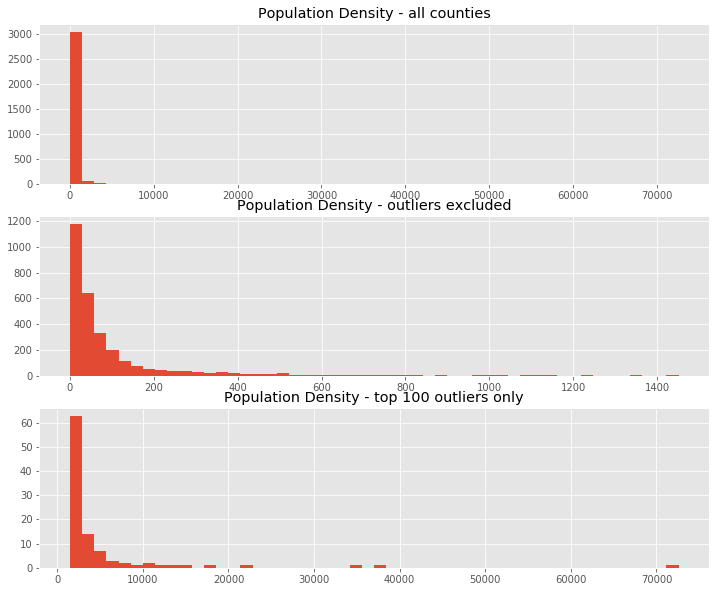

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(12,10))


ax1.hist(pop_density['pop_den_2015'], bins=50)
ax1.set_title('Population Density - all counties')
# pop_density.hist('pop_den_2015', bins=50, figsize=(8,4), {title:'Population Density - all counties'});

# split the top 100 counties by density from the rest of the counties

pop_last_100 = pop_density.sort_values('pop_den_2015')[-100:]
pop_everything_else = pop_density.sort_values('pop_den_2015')[:-100]

ax2.hist(pop_everything_else['pop_den_2015'], bins=50)
ax2.set_title('Population Density - outliers excluded')

ax3.hist(pop_last_100['pop_den_2015'], bins=50)
ax3.set_title('Population Density - top 100 outliers only');

## Birth rate histogram

- basically normally distributed, no concerns here 

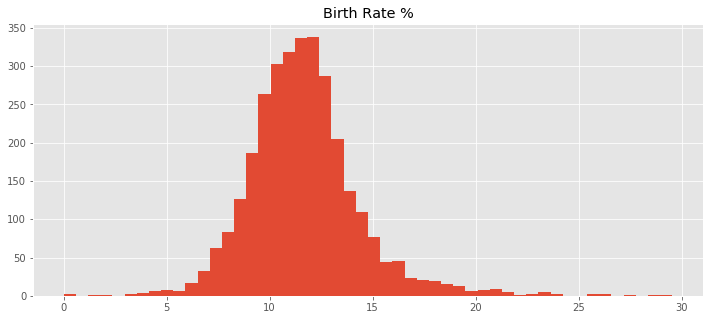

In [7]:
fig, ax = plt.subplots(1,figsize=(12,5))

ax.hist(birth_rate['Birth_Rate_2015'], bins=50)
ax.set_title('Birth Rate %');

## Distributions of race and education

This suggests that most counties are mostly white. The magnitude in the plot makesthe data look improbable, but 
the census bureau reported that as of 2016, 76.9% of the population is white. 

See https://www.census.gov/quickfacts/fact/table/US/PST045216 for further details


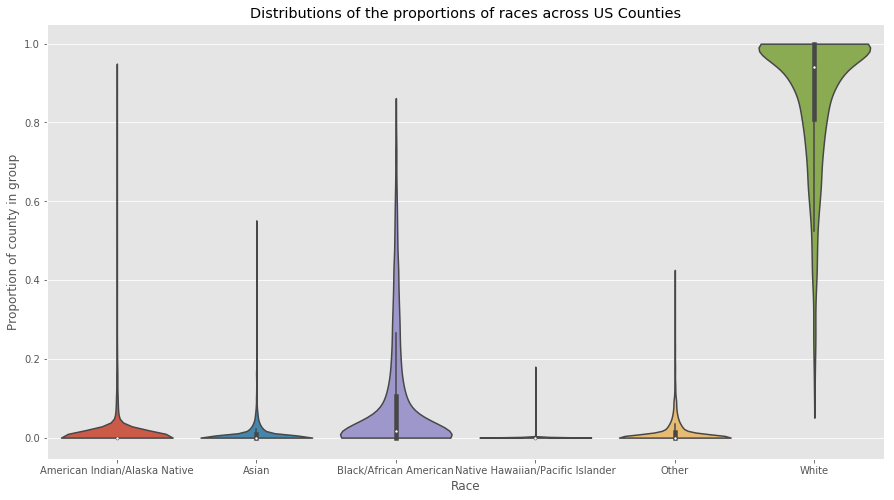

In [8]:
fig, ax = plt.subplots(1, figsize=(15,8))

sns.violinplot(data=race_pivot.loc[:,['American Indian/Alaska Native', 'Asian',
       'Black/African American', 'Native Hawaiian/Pacific Islander', 'Other',
       'White']],ax=ax, scale='count', cut=0);

ax.set_ylabel('Proportion of county in group')
ax.set_xlabel('Race')
ax.set_title('Distributions of the proportions of races across US Counties');
print('This suggests that most counties are mostly white. The magnitude in the plot makes\
the data look improbable, but \n\
the census bureau reported that as of 2016, 76.9% of the population is white. \n\n\
See https://www.census.gov/quickfacts/fact/table/US/PST045216 for further details')

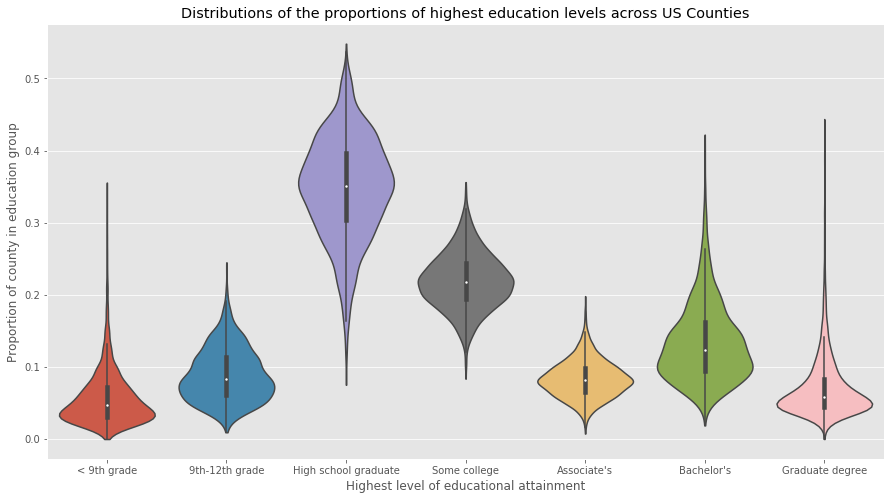

In [9]:
fig, ax = plt.subplots(1, figsize=(15,8))

education_groups =education_25yr.loc[:,['Less than 9th grade', '9th to 12th grade, no diploma',\
                                          'High school graduate (includes equivalency)','Some college, no degree', \
                                          "Associate's degree", "Bachelor's degree",\
                                          'Graduate or professional degree']]
education_groups.columns = ['< 9th grade', '9th-12th grade','High school graduate','Some college', \
                                          "Associate's", "Bachelor's",\
                                          'Graduate degree']
sns.violinplot(data=education_groups,ax=ax, scale='count', cut=0);

ax.set_ylabel('Proportion of county in education group')
ax.set_xlabel('Highest level of educational attainment')
ax.set_title('Distributions of the proportions of highest education levels across US Counties');

## Relationships between two variables

In [10]:
def corr_heat(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(12, 12))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},xticklabels=corr.index, yticklabels=corr.columns)
    plt.xticks(rotation=60, ha="right")
    plt.yticks(rotation=0)
    ax.set_title("Correlation Heat Map")
    plt.show()

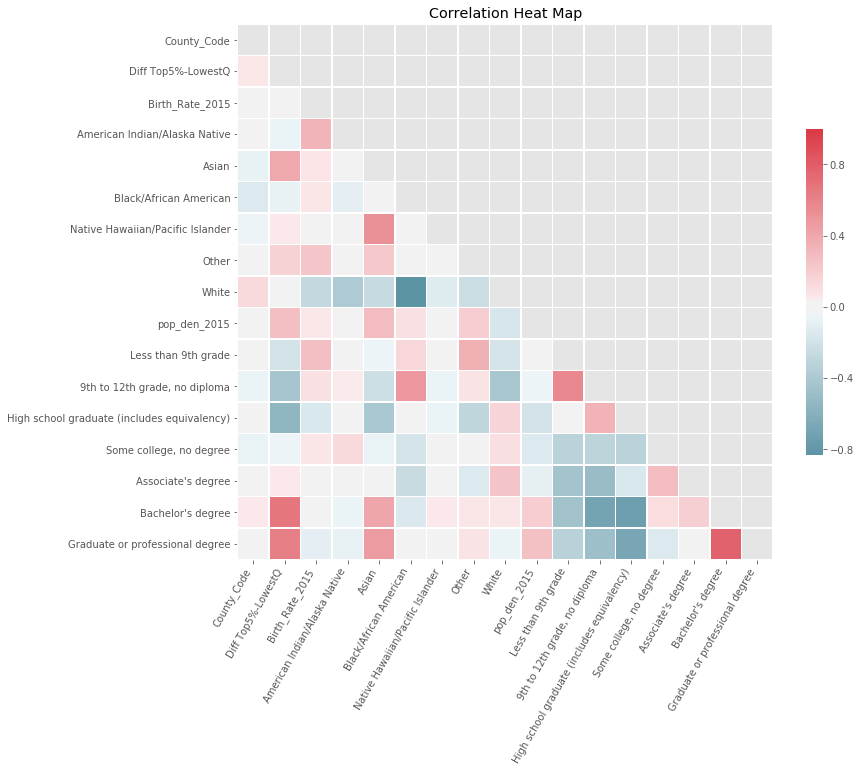

In [11]:
corr_heat(pd.DataFrame(predictors_target))

Covariance Notes:
- Covariance between proportion of pop with a Bachelor's degree and proportion of pop with a graduate degree.
- High covariance between proportion of Bachelor's/Grad degrees and income inequality. This is the opposite of what I expected given that higher education is said to facilitate socioeconomic mobility while income inequality hinders it.
- Higher proportion of population with High School as highest level of educational attainment strongly *inversely* covaries with income inequality. Is this because in those towns, everybody is poor?

/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


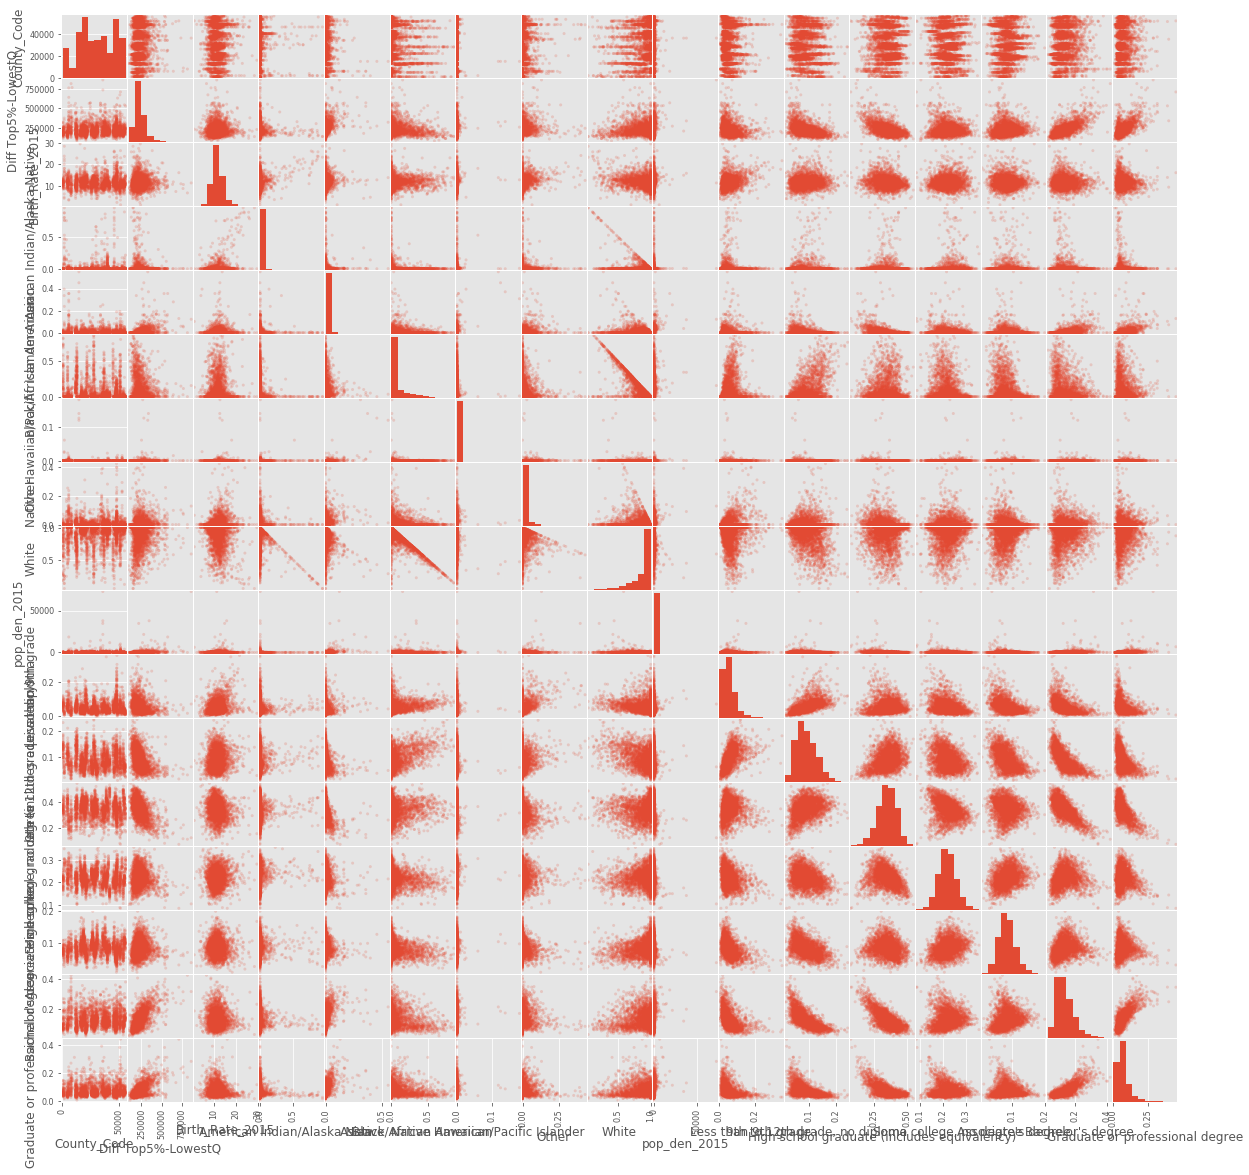

In [12]:
scattermatrix = scatter_matrix(predictors_target, alpha=0.2,figsize=(20,20), diagonal="hist")

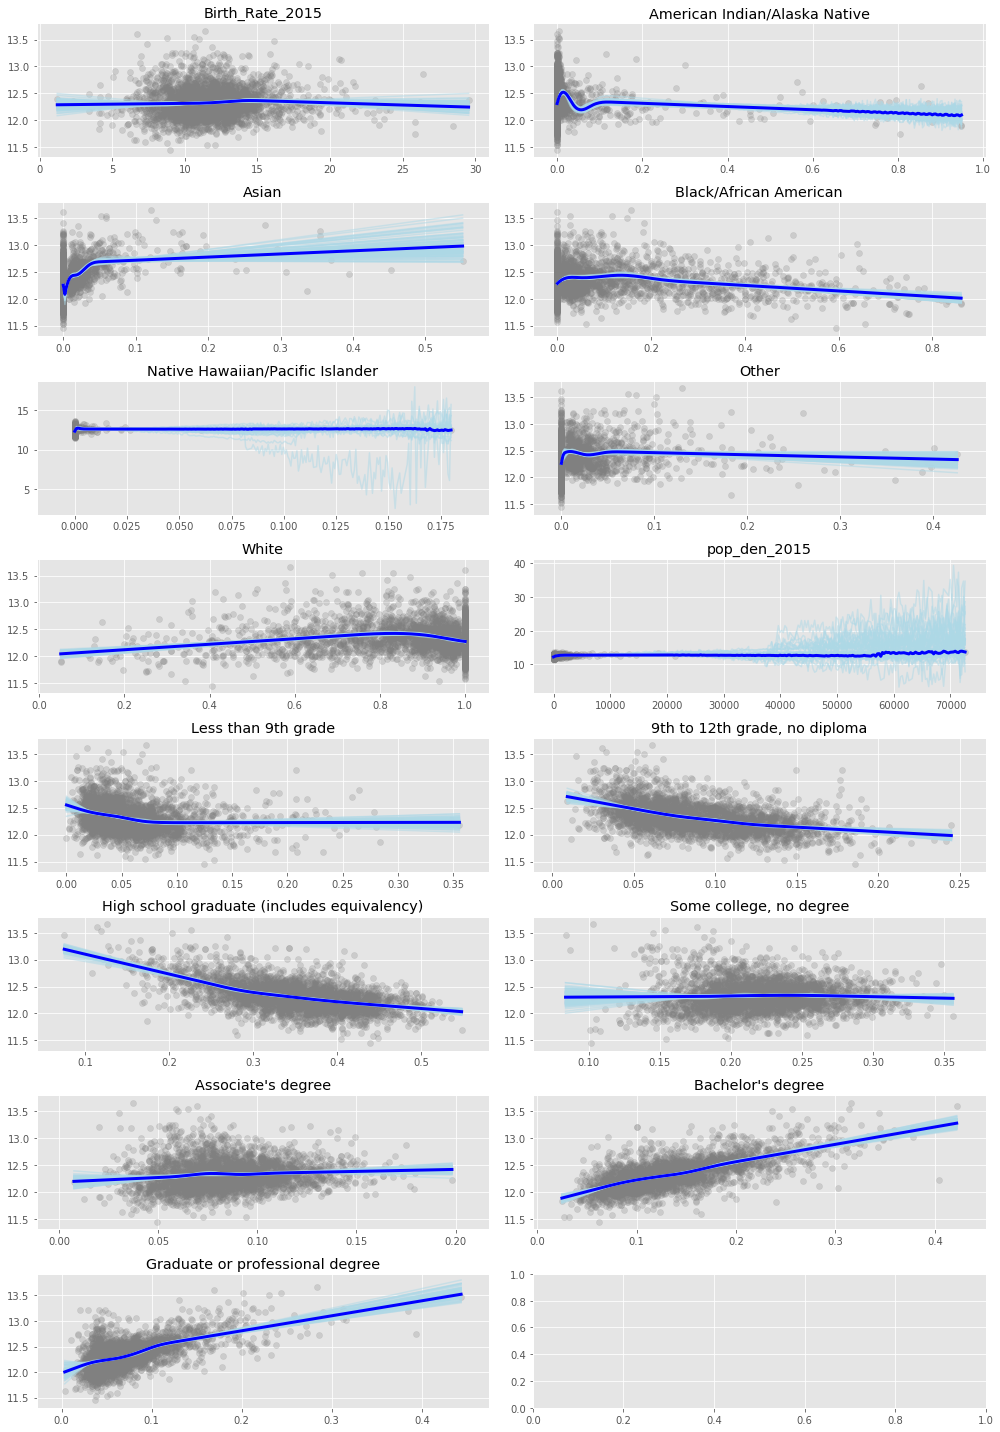

In [13]:
#Plot univariate plots against log of income inequality
fig, axs = plt.subplots(8, 2, figsize=(14, 20))
l1=['Birth_Rate_2015', 'American Indian/Alaska Native',\
    'Asian','Black/African American', 'Native Hawaiian/Pacific Islander',\
    'Other','White', 'pop_den_2015','Less than 9th grade',\
    '9th to 12th grade, no diploma','High school graduate (includes equivalency)',\
    'Some college, no degree', "Associate's degree", "Bachelor's degree",\
    'Graduate or professional degree']

univariate_plot_names = predictors_target[l1]

for name, ax in zip(univariate_plot_names, axs.flatten()):
    plot_univariate_smooth(ax,
                           predictors_target[name].values.reshape(-1, 1),
                           np.log(predictors_target['Diff Top5%-LowestQ']),
                           bootstrap=100)
    ax.set_title(name)
fig.tight_layout()

## Summary of EDA



### Impressions from data visualization
- Target variable, income inequality, not normally distributed because:
            + Extreme values
            + Zero bound
    - To deal with this, took the log of the target in the target variable, which resulted in a more normal distribution
- American counties are heavily weighted toward white populations

### Variable treatment to-do:
- Need to deal with high covariance and inverse covariance in predictors - will do this through ridge regression
- Variables are mostly linearly related with the log of income inequality. Exceptions are:
    - Asian
        - weighted by zeros but in a way that looks like it might be significant
        - I would prefer my model be interpretable so I will stay away from splines if possible. However, if the model is not performing well, I will consider modeling the asian variable with cubic splines.
    - White
        - right around 90% it looks like an increase in proportion of whites results in a decrease in income inequality
        - the inflection is not very severe
    - Less than 9th grade, apparent inflection point at 7.5%, also not very severe
    

# Regression Plan

- Basic linear regression since it is the simplest and will be the best option if it has
    - good performance
    - interpretable coefficients
- Lasso vs Ridge:
    - Lasso will randomly drop one of two correlated variables. We don't want that because undergrad and grad are meaningflly different.
    - Will instead be using ridge to:
        - keep in variables
        - ensure interpretability of coefficients
        - deal with correlated variances

## Define y and X and train/test/split

In [14]:
# Define y and X
y = np.log(predictors_target['Diff Top5%-LowestQ'])
X = predictors_target.loc[:, ['Birth_Rate_2015','pop_den_2015','American Indian/Alaska Native','Asian'\
                              ,'Black/African American','Native Hawaiian/Pacific Islander','Other','White', \
                              'Less than 9th grade','9th to 12th grade, no diploma',\
                              'High school graduate (includes equivalency)','Some college, no degree', \
                              "Associate's degree", "Bachelor's degree",'Graduate or professional degree']]


# Test_train_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)

## Basic Linear Regression

### Pipeline

In [15]:
# Pipeline is just standardize predictors and then feed them into a linear model. 
simple_linear_model_pipeline = Pipeline([
    ('Standardizer', StandardScaler()),
    ('Linear Regression', LinearRegression())
])

# Fit on X_train, standardize/predict on X_test

simple_linear_model = simple_linear_model_pipeline
simple_linear_model.fit(X_train, y_train)
y_predict_linear = simple_linear_model.predict(X_test)

In [16]:
def coef_df(model,var_names):
    '''
    inputs:
    
    model using for estimation - must have .coef_ attribute
    
    var_names - list of variable names that correspond to the coefficient
    
    
    returns:
    matrix of model coefficient names and values, sorted ascending by coefficient value
    
    '''
    coef_matrix = pd.DataFrame(np.ones((model.coef_.shape[0],2)))
    coef_matrix.columns = ['Name', 'Coefficient']
    coef_matrix['Name']=X_test.columns
    coef_matrix['Coefficient'] = model.coef_
    coef_matrix = coef_matrix.sort_values('Coefficient')
    
    return coef_matrix   

In [17]:
linear_coef = coef_df(simple_linear_model.named_steps['Linear Regression'], X.columns)
linear_coef.round(2)

Name   Coefficient
10  High school graduate (includes equivalency) -3.769612e+12
13                            Bachelor's degree -2.897292e+12
14              Graduate or professional degree -2.215103e+12
11                      Some college, no degree -2.038697e+12
8                           Less than 9th grade -1.982688e+12
9                 9th to 12th grade, no diploma -1.937474e+12
12                           Associate's degree -1.348102e+12
1                                  pop_den_2015  1.000000e-02
0                               Birth_Rate_2015  1.000000e-02
5              Native Hawaiian/Pacific Islander  1.404019e+09
3                                         Asian  8.031531e+09
6                                         Other  9.791808e+09
2                 American Indian/Alaska Native  2.154488e+10
4                        Black/African American  3.933346e+10
7                                         White  4.515602e+10

### Bootstrap Coefficients

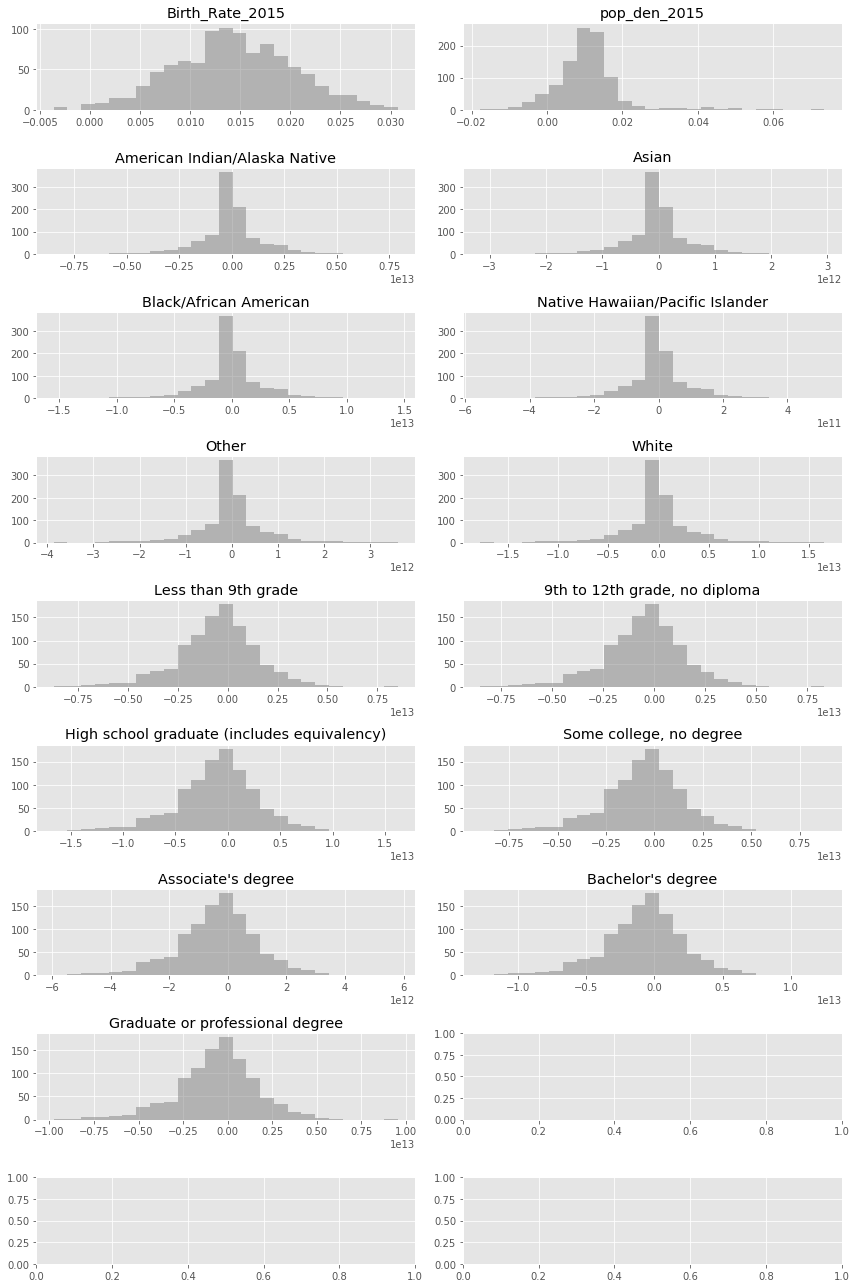

In [18]:
# This creates a list of models, one for each bootstrap sample.
standardizer = StandardScaler()
standardizer.fit(X_train)
X_train_standard = standardizer.transform(X_train)

models = bootstrap_train(
    LinearRegression, 
    X_train_standard, 
    y_train.values
)


fig, axs = plot_bootstrap_coefs(models, X_train.columns, n_col=2)
fig.tight_layout()

## How well is the Linear model doing?
    - Standard measurement - root mean squared error
    - Predictions vs actuals
    - Plot residuals

In [19]:
def plot_many_predicteds_vs_actuals(var_names, X_test, y_test, y_predict, n_bins=50):
    fig, axs = plt.subplots(len(var_names), figsize=(12, 4.5*len(var_names)))
    for ax, name in zip(axs, var_names):
        x = X_test[name]
        predicteds_vs_actuals(ax, x, y_test, y_predict)
        ax.set_title("{} Predicteds vs. Actuals".format(name))
    return fig, axs

In [20]:
def residual_plot(ax, x, y, y_hat, n_bins=50):
    fig.tight_layout()
    residuals = y - y_hat
    ax.axhline(0, color="black", linestyle="--")
    ax.scatter(x, residuals, color="grey", alpha=0.5)
    ax.set_ylabel("Residuals ($y - \hat y$)")

In [21]:
def plot_many_residuals(var_names, X_test, y_test, y_predict, n_bins=50):
    fig, axs = plt.subplots(len(var_names), figsize=(12, 3*len(var_names)))
    for ax, name in zip(axs, var_names):
        x = X_test[name]
        residual_plot(ax, x, y_test, y_predict)
        ax.set_xlabel(name)
        ax.set_title("Model Residuals by {}".format(name))
    return fig, axs

### Mean Squared error and y vs y hat

The root mean squared error for this model is 0.2017 and the mean squared error is 0.0407


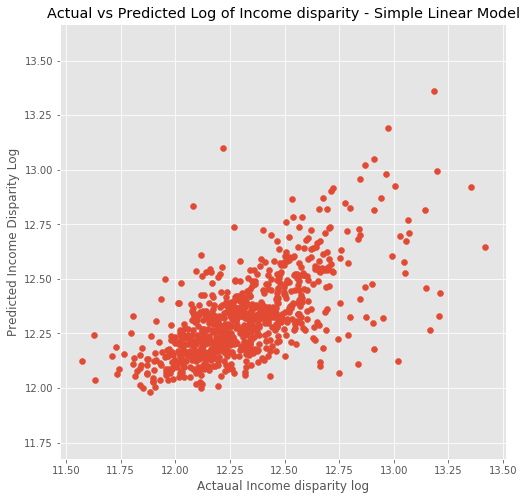

In [22]:
mse_linear = mean_squared_error(y_test, y_predict_linear)
rmse_linear = mse_linear**0.5
print('The root mean squared error for this model is {:.4f} and the mean squared error is {:.4f}'.\
      format(rmse_linear, mse_linear))

# scatter of actuals vs predicted overall
fig = plt.figure(figsize=(8,8))
plt.scatter(y_test, y_predict_linear)
plt.ylabel("Predicted Income Disparity Log")
plt.xlabel("Actaual Income disparity log")
plt.title('Actual vs Predicted Log of Income disparity - Simple Linear Model')
plt.axis('equal');

Text(0.5,6,'$\\hat y$')

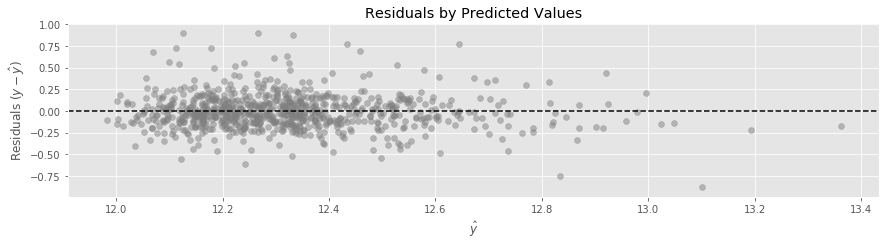

In [23]:
fig, ax = plt.subplots(figsize=(12, 3))
fig.tight_layout()
residuals = y_test - y_predict_linear
ax.axhline(0, color="black", linestyle="--")
ax.scatter(y_predict_linear, residuals, color="grey", alpha=0.5)
ax.set_ylabel("Residuals ($y - \hat y$)")
ax.set_title("Residuals by Predicted Values")
ax.set_xlabel("$\hat y$")

### How is the model doing by predictor? 

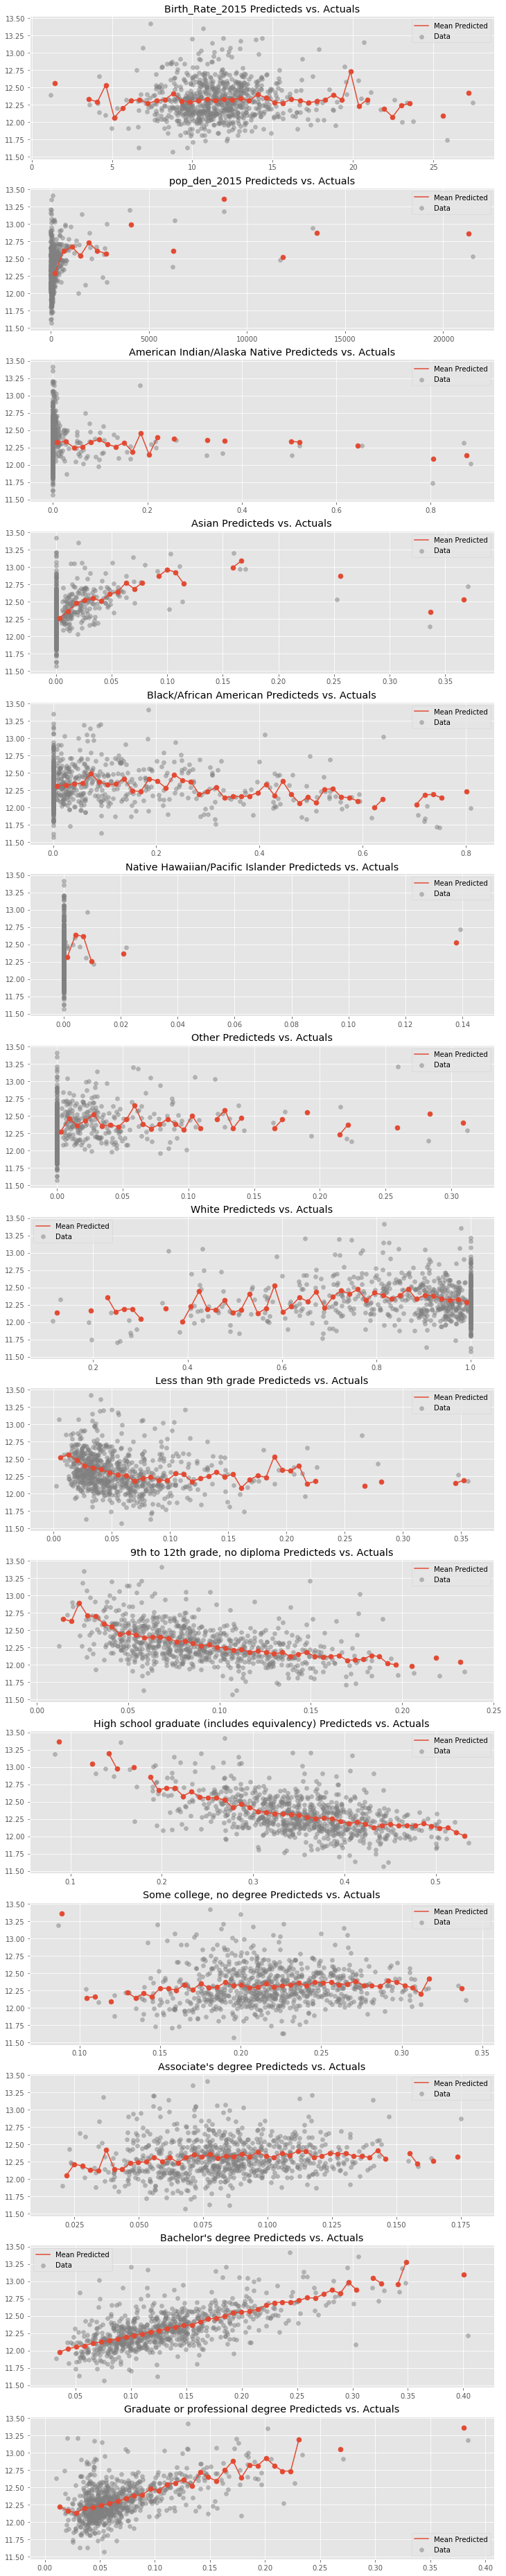

In [24]:
plot_many_predicteds_vs_actuals(X.columns, X_test, y_test, y_predict_linear);

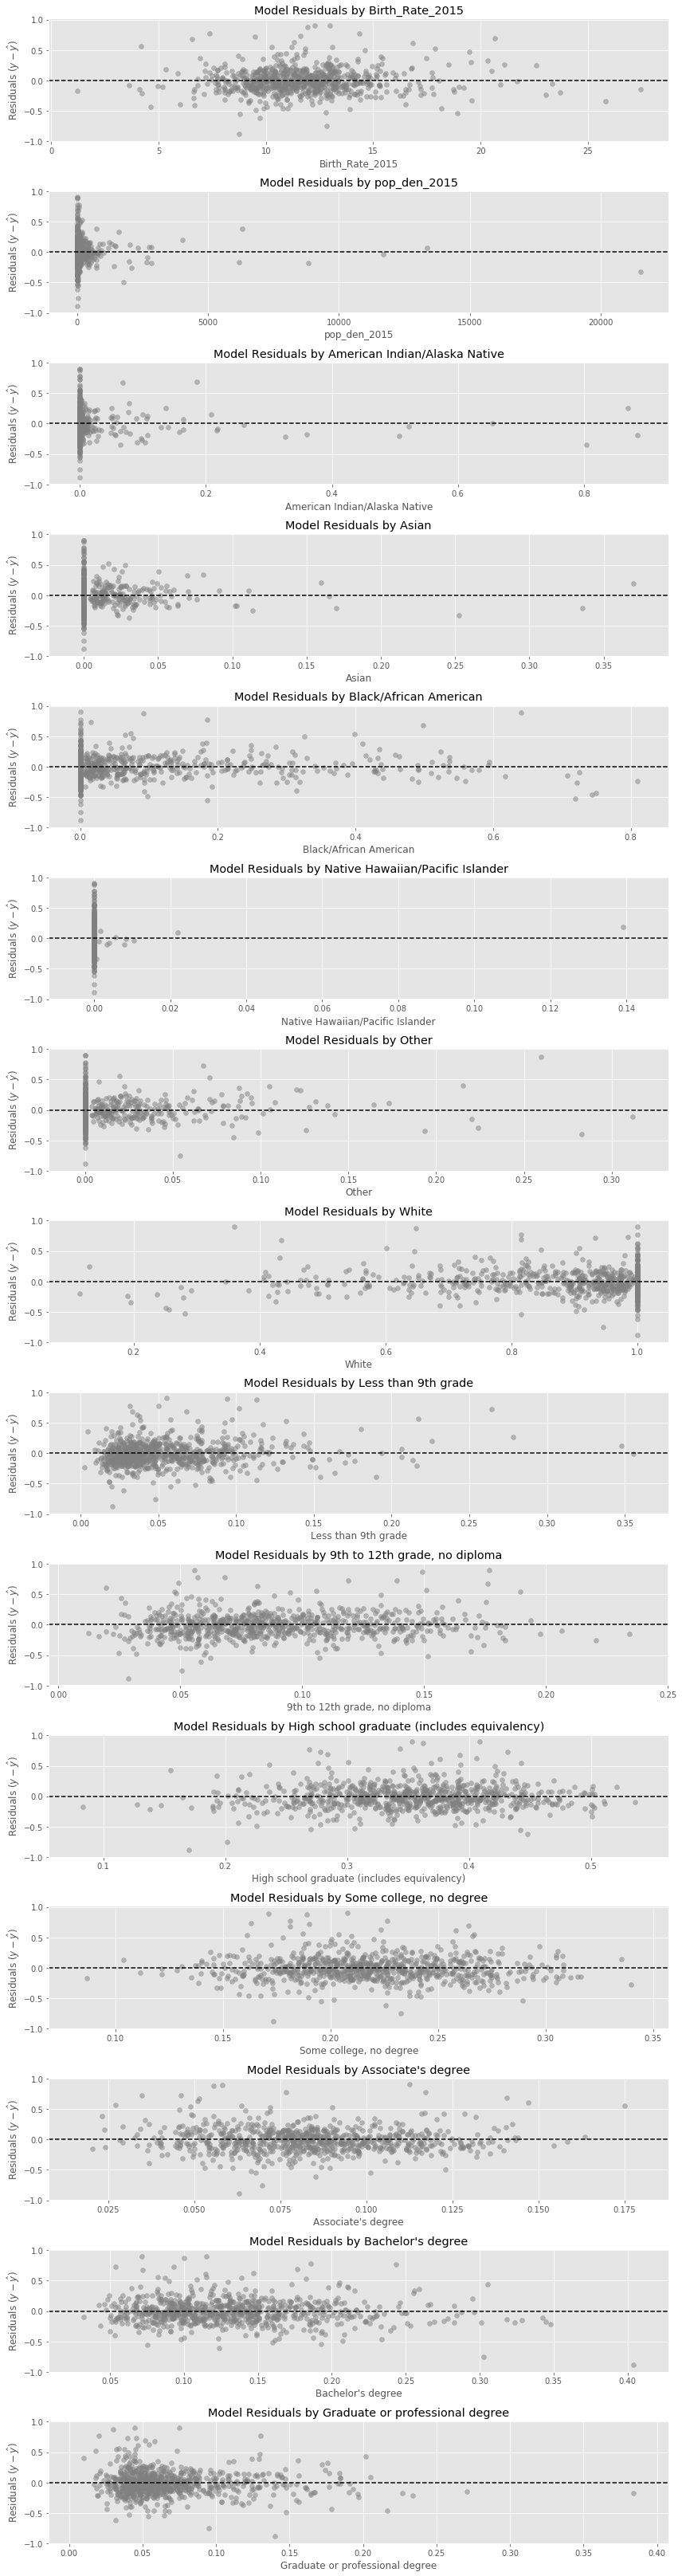

In [25]:
fig, axs = plot_many_residuals(X.columns, X_test, y_test, y_predict_linear)
fig.tight_layout()

#  Ridge Regression
- Train/test split then pipeline
- Pipeline will
    - not gonna spline any variables to keep interpretibility
    - normalize all predictors
    - **not**  get rid of outliers because I think outliers are important to predict
- Ridge regression
    - use k fold cross-validation to figure out optimal alpha


## Pipeline

In [26]:
# Define y and X - the same as above for the linear model. Need to standardize X because that was 
# done above in the same pipeline that fit Linear Regression

standardizer = StandardScaler()
standardizer.fit(X_train)
X_train_standardized = standardizer.transform(X_train)
X_test_standardized = standardizer.transform(X_test)

## Use k-fold cross-validation to pick an alpha for the Ridge Regression

In [27]:
def cv(X, y, model, param_dict, n_folds=10):
    """Estimate the in- and out-of-sample error of a model using cross
    validation.
 
    Parameters
    ----------
 
    X: np.array
      Matrix of predictors.
 
    y: np.array
      Target array.
 
    model: sklearn model object.
      The estimator to fit.  Must have fit and predict methods.
 
    param_dict: dictionary of paramters to use in sklearn model
    
    n_folds: int
      The number of folds in the cross validation.
 
    random_seed: int
      A seed for the random number generator, for repeatability.
 
    Returns
    -------
 
    results_train, results_test: tuple of arrays
      The training and testing errors for each fold of cross validation.
    """
    kf = KFold(n_splits=n_folds)
    results_train = np.array([])  
    results_test = np.array([])    #np.array([])
    for train_index, test_index in kf.split(X):
        # Split into train and test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Standardize data, fit on training set, transform training and test.
        scaler = StandardScaler()
        scaler.fit(X_train)
        scaled_X_train = scaler.transform(X_train)
        scaled_X_test = scaler.transform(X_test)
        # Fit ridge regression to training data.
        regularized = model(**param_dict)
        regularized.fit(scaled_X_train, y_train)
        # Make predictions.
        reg_predict_train = regularized.predict(X_train)
        reg_predict_test = regularized.predict(X_test)
        # Calclate MSE.
        mse_train = mean_squared_error(reg_predict_train, y_train)
        mse_test = mean_squared_error(reg_predict_test, y_test)
        # Record the MSE in a numpy array.
        results_train = np.append(results_train, mse_train)
        results_test = np.append(results_test, mse_test)
    return results_train, results_test

In [28]:
def k_fold_to_pick_alpha(X, y, model, alphas, n_folds=10, **kwargs):
    """Train a regularized regression model using cross validation at various
    values of alpha.
 
    Parameters
    ----------
 
    X: np.array
      Matrix of predictors.
 
    y: np.array
      Target array.
 
    model: sklearn model class
      A class in sklearn that can be used to create a regularized regression
      object.  Options are `Ridge` and `Lasso`.
 
    alphas: numpy array
      An array of regularization parameters.
 
    n_folds: int
      Number of cross validation folds.
 
    Returns
    -------
 
    
    """
    cv_errors_train = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                     columns=alphas)
    cv_errors_test = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                        columns=alphas)
    for alpha in alphas:
        param_dict = {'alpha': alpha}
        mses = cv(X, y, model, param_dict, n_folds)
        cv_errors_train[alpha] = mses[0]
        cv_errors_test[alpha] = mses[1]
    
    # Average error RMSEs for each alpha to determine which alpha creates a model that generalizes best.
    alpha_error_means = cv_errors_test.mean()
    min_mse = alpha_error_means.min()
    best_alpha = np.argmin(alpha_error_means)
    return cv_errors_test, alpha_error_means, best_alpha, min_mse

In [29]:
orders_of_magnitude = np.arange(-2,15)
alphas = (np.ones(len(orders_of_magnitude))*10)**orders_of_magnitude
cv_errors_test_o, alpha_error_means_o, best_alpha_o, min_mse_o = k_fold_to_pick_alpha(X_train_standardized, \
                                                                y_train.values, Ridge, alphas, n_folds=10)

print('The best order of magnitude for alpha is around {:.0g}, which results in an average \
mean \nsquared error of {:.7f}.'.format(best_alpha_o, min_mse_o))

print('I will now test alphas around that order of magnitude to attempt to narrow the value of min_mse \
down \nfurther')

The best order of magnitude for alpha is around 1e+01, which results in an average mean 
squared error of 0.0367500.
I will now test alphas around that order of magnitude to attempt to narrow the value of min_mse down 
further


In [30]:
# alphas = np.linspace(20,50,100)
# cv_errors_test, alpha_error_means, best_alpha, min_mse = k_fold_to_pick_alpha\
# (X_train_standardized, y_train.values, Ridge, alphas, n_folds=10)


# print(alpha_error_means, best_alpha)

In [35]:
alphas = np.linspace(10,100,100)
cv_errors_test, alpha_error_means, best_alpha, min_mse = k_fold_to_pick_alpha(X_train_standardized,\
                                    y_train.values, Ridge, alphas, n_folds=10)
print('Narrowing the range to zero in on the best alpha resulted in an alpha of {:.2g},\
which \nminimized the average root mean squared error at {:.7f}.\n\nThis is the about same as the \
error we got with alpha=10 and is a bit better than the the simple linear regression mse'\
      .format(best_alpha, min_mse))

Narrowing the range to zero in on the best alpha resulted in an alpha of 34,which 
minimized the average root mean squared error at 0.0367464.

This is the about same as the error we got with alpha=10 and is a bit better than the the simple linear regression mse


### Check my best alpha mse with sklearn cross_val

In [36]:
ridge = Ridge(alpha=best_alpha)
cvs = cross_val_score(ridge, X_train_standard, y_train, cv=10, scoring = 'neg_mean_squared_error')
print(cvs.mean())

-0.0367861467955


### Find best alpha with GridSearch

In [37]:
'''sklearn.model_selection.cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv=None, 
n_jobs=1, verbose=0, fit_params=None, pre_dispatch=‘2*n_jobs’)

class sklearn.model_selection.GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, 
n_jobs=1, iid=True, refit=True, cv=None, verbose=0, pre_dispatch=‘2*n_jobs’, error_score=’raise’, 
return_train_score=’warn’)
'''
ridge1 = Ridge()
grid_search_results = GridSearchCV(ridge1, {'alpha':alphas},scoring = 'neg_mean_squared_error')
             
grid_search_results.fit(X_train_standardized, y_train.values)

grid_search_results.best_params_

{'alpha': 47.272727272727273}

## With alpha chosen, fit Ridge Regression on X_train and predict on X_test

In [38]:
def coef_df(model,var_names):
    '''
    inputs:
    
    model using for estimation - must have .coef_ attribute
    
    var_names - list of variable names that correspond to the coefficient
    
    
    returns:
    matrix of model coefficient names and values, sorted ascending by coefficient value
    
    '''
    coef_matrix = pd.DataFrame(np.ones((model.coef_.shape[0],2)))
    coef_matrix.columns = ['Name', 'Coefficient']
    coef_matrix['Name']=X_test.columns
    coef_matrix['Coefficient'] = model.coef_
    coef_matrix = coef_matrix.sort_values('Coefficient')
    
    return coef_matrix   

In [39]:
ridge_regression = Ridge(alpha = best_alpha)
ridge_regression.fit(X_train_standardized, y_train)
y_predict_ridge = ridge_regression.predict(X_test_standardized)
ridge_mse = mean_squared_error(y_predict_ridge, y_test)
ridge_rmse = ridge_mse**0.5
target_log_std_dev = y.std()


ridge_coef = coef_df(ridge_regression, X_test.columns)
ridge_coef

Name  Coefficient
10  High school graduate (includes equivalency)    -0.043988
9                 9th to 12th grade, no diploma    -0.033712
11                      Some college, no degree    -0.030034
8                           Less than 9th grade    -0.018338
12                           Associate's degree    -0.008752
2                 American Indian/Alaska Native    -0.007491
5              Native Hawaiian/Pacific Islander    -0.005935
4                        Black/African American    -0.005187
7                                         White    -0.000250
1                                  pop_den_2015     0.010510
0                               Birth_Rate_2015     0.014402
14              Graduate or professional degree     0.017663
3                                         Asian     0.020457
6                                         Other     0.022542
13                            Bachelor's degree     0.104027

# How well is the Ridge model doing?
    - Standard measurement - root mean squared error
    - Predictions vs actuals
    - Plot residuals

###  y vs yhat overall


The root mean squared error for this model is 0.2015 and the std dev for the target is 0.2736


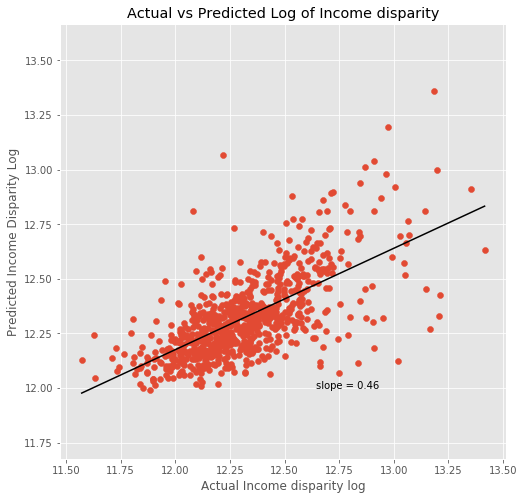

In [45]:
print('\nThe root mean squared error for this model is {:.4f} and the std dev for the target is {:.4f}'.format(ridge_rmse, target_log_std_dev))

# scatter of actuals vs predicted overall
fig = plt.figure(figsize=(8,8))
plt.scatter(y_test, y_predict_ridge)
plt.ylabel("Predicted Income Disparity Log")
plt.xlabel("Actual Income disparity log")
plt.title('Actual vs Predicted Log of Income disparity')
plt.axis('equal');
line_of_best_fit = np.polyfit(y_test, y_predict_ridge, 1)
plt.plot(np.unique(y_test), np.poly1d((line_of_best_fit))(np.unique(y_test)), color='black');
plt.text(0.4, .5, 'slope = {:.2f}'.format(line_of_best_fit[0]),horizontalalignment='right',\
         verticalalignment='top', transform=ax.transAxes); 

Text(0.5,6,'$\\hat y$')

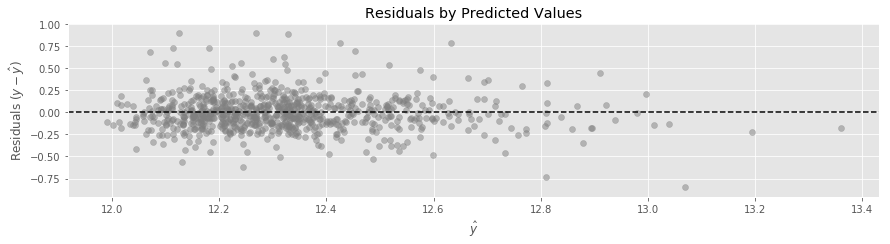

In [48]:
#Scatter of 
fig, ax = plt.subplots(figsize=(12, 3))
fig.tight_layout()
residuals = y_test - y_predict_ridge
ax.axhline(0, color="black", linestyle="--")
ax.scatter(y_predict_ridge, residuals, color="grey", alpha=0.5)
ax.set_ylabel("Residuals ($y - \hat y$)")
ax.set_title("Residuals by Predicted Values")
ax.set_xlabel("$\hat y$")

### y vs yhat by predictor

In [49]:
# plot_many_predicteds_vs_actuals(X.columns, X_test, y_test, y_predict);

In [50]:
# fig, axs = plot_many_residuals(X.columns, X_test, y_test, y_predict)
# fig.tight_layout()

# Ridge Regression on non-log target

In [51]:
#Define y no log, X no log is the same as above for the linear model
y_no_log = predictors_target['Diff Top5%-LowestQ']
X_no_log = predictors_target.loc[:, ['Birth_Rate_2015','pop_den_2015','American Indian/Alaska Native','Asian'\
                              ,'Black/African American','Native Hawaiian/Pacific Islander','Other','White', \
                              'Less than 9th grade','9th to 12th grade, no diploma',\
                              'High school graduate (includes equivalency)','Some college, no degree', \
                              "Associate's degree", "Bachelor's degree",'Graduate or professional degree']]


# Test_train_split
X_train_no_log, X_test_no_log, y_train_no_log, y_test_no_log = train_test_split(X_no_log, y_no_log)

# Fit on X_train, standardize/predict on X_test

standardizer = StandardScaler()
standardizer.fit(X_train_no_log)
X_train_no_log_standardized = standardizer.transform(X_train_no_log)
X_test_no_log_standardized = standardizer.transform(X_test_no_log)


In [52]:
orders_of_magnitude = np.arange(-2,15)
alphas = (np.ones(len(orders_of_magnitude))*10)**orders_of_magnitude
cv_errors_test_o, alpha_error_means_o, best_alpha_o, min_mse_o = k_fold_to_pick_alpha\
        (X_train_no_log_standardized, y_train_no_log.values, Ridge, alphas, n_folds=10)

min_rmse_no_log = min_mse_o**0.5
print('The best order of magnitude for alpha is around {:.0g}, which results in an average \
mean \nsquared error of {:.2f} $^2, or a root mean squared error of ${:.2f}.'.format(best_alpha_o,\
                                                                                     min_mse_o, min_rmse_no_log))

print('Further investigation showed 100 was truly the optimal alpha')


The best order of magnitude for alpha is around 1e+02, which results in an average mean 
squared error of 2615025144.06 $^2, or a root mean squared error of $51137.32.
Further investigation showed 100 was truly the optimal alpha


## With alpha chosen, fit no log Ridge Regression on X_train and predict on X_test

In [53]:
ridge_regression_no_log = Ridge(alpha = 100)
ridge_regression_no_log.fit(X_train_no_log_standardized, y_train_no_log)
y_predict_no_log = ridge_regression_no_log.predict(X_test_no_log_standardized)
ridge_no_log_mse = mean_squared_error(y_predict_no_log, y_test_no_log)

ridge_no_log_coeff = coef_df(ridge_regression_no_log, X_test_no_log.columns)
ridge_no_log_coeff

Name   Coefficient
10  High school graduate (includes equivalency) -11119.813495
11                      Some college, no degree  -9671.813160
9                 9th to 12th grade, no diploma  -8680.260290
12                           Associate's degree  -3818.673015
8                           Less than 9th grade  -2610.460393
5              Native Hawaiian/Pacific Islander  -1703.607692
2                 American Indian/Alaska Native  -1612.523180
4                        Black/African American  -1229.810886
7                                         White   -245.773403
0                               Birth_Rate_2015   2436.881993
6                                         Other   4786.853334
3                                         Asian   6247.532281
1                                  pop_den_2015   6258.285498
14              Graduate or professional degree   8468.243551
13                            Bachelor's degree  24285.785532

# How well is the no log Ridge model doing?
    - Standard measurement - root mean squared error
    - Predictions vs actuals
    - Plot residuals

In [54]:
ridge_no_log_rmse = ridge_no_log_mse**0.5
mean_no_log_target = predictors_target['Diff Top5%-LowestQ'].mean()
stddev_no_log_target = predictors_target['Diff Top5%-LowestQ'].std()
median_no_log_target = predictors_target['Diff Top5%-LowestQ'].median()
print('The root mean squared error for this model is ${:.2f}. \nThe original target distribution has a median of ${:.2f}, mean \
of ${:.2f} and a std deivation of ${:.2f}'.format(ridge_no_log_rmse, median_no_log_target, mean_no_log_target, stddev_no_log_target))

The root mean squared error for this model is $53427.60. 
The original target distribution has a median of $220111.00, mean of $234577.41 and a std deivation of $73314.91


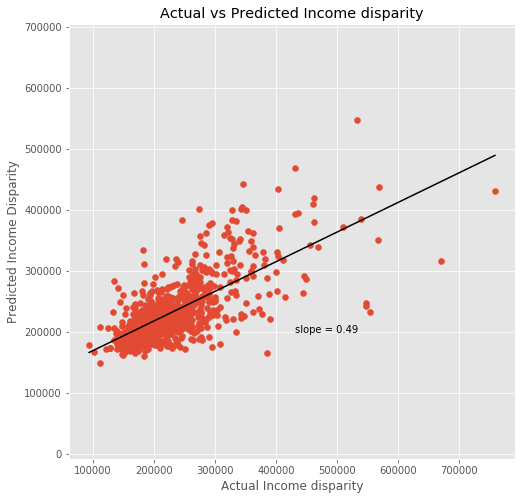

In [55]:
# scatter of actuals vs predicted overall
fig = plt.figure(figsize=(8,8))
plt.scatter(y_test_no_log, y_predict_no_log) 
plt.ylabel("Predicted Income Disparity")
plt.xlabel("Actual Income disparity")
plt.title('Actual vs Predicted Income disparity')
plt.axis('equal');
line_of_best_fit = np.polyfit(y_test_no_log, y_predict_no_log, 1)
plt.plot(np.unique(y_test_no_log), np.poly1d((line_of_best_fit))(np.unique(y_test_no_log)), color='black');
plt.text(0.4, 0.85, 'slope = {:.2f}'.format(line_of_best_fit[0]),horizontalalignment='right',\
         verticalalignment='top', transform=ax.transAxes); 

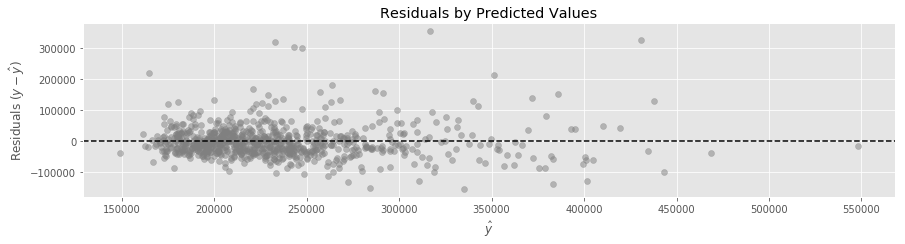

In [57]:
#Scatter of residuals
fig, ax = plt.subplots(figsize=(12, 3))
fig.tight_layout()
residuals = y_test_no_log - y_predict_no_log
ax.axhline(0, color="black", linestyle="--")
ax.scatter(y_predict_no_log, residuals, color="grey", alpha=0.5)
ax.set_ylabel("Residuals ($y - \hat y$)")
ax.set_title("Residuals by Predicted Values")
ax.set_xlabel("$\hat y$");

In [58]:
linear_rmse_standardized= rmse_linear/target_log_std_dev
ridge_log_rmse_standardized = ridge_rmse/target_log_std_dev
ridge_no_log_rmse_standardized = ridge_no_log_rmse/stddev_no_log_target

### How is the model doing by predictor? 

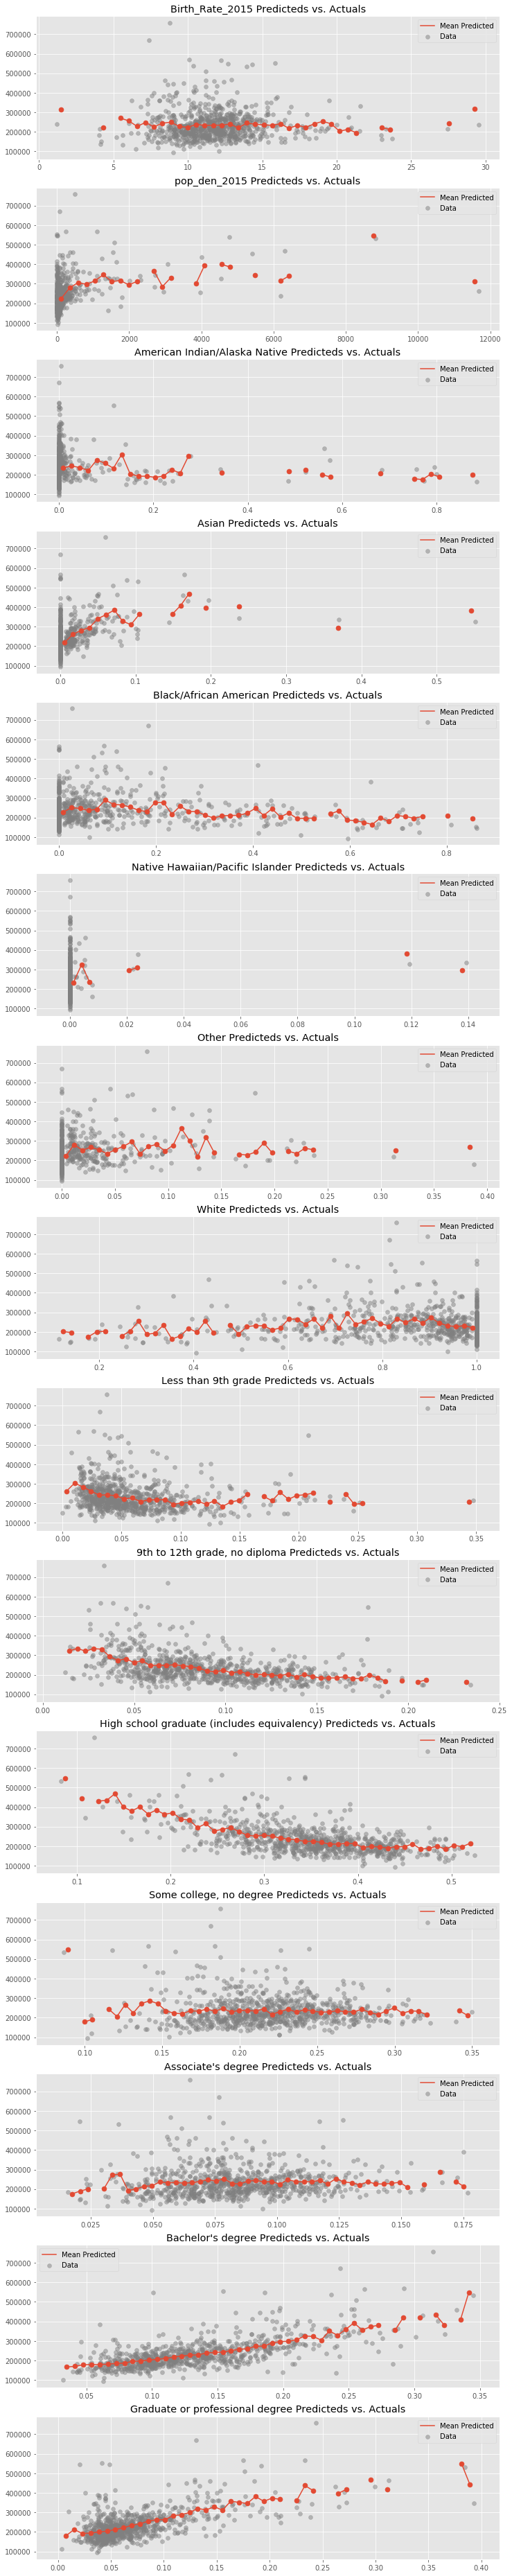

In [84]:
plot_many_predicteds_vs_actuals(X.columns, X_test_no_log, y_test_no_log, y_predict_no_log);

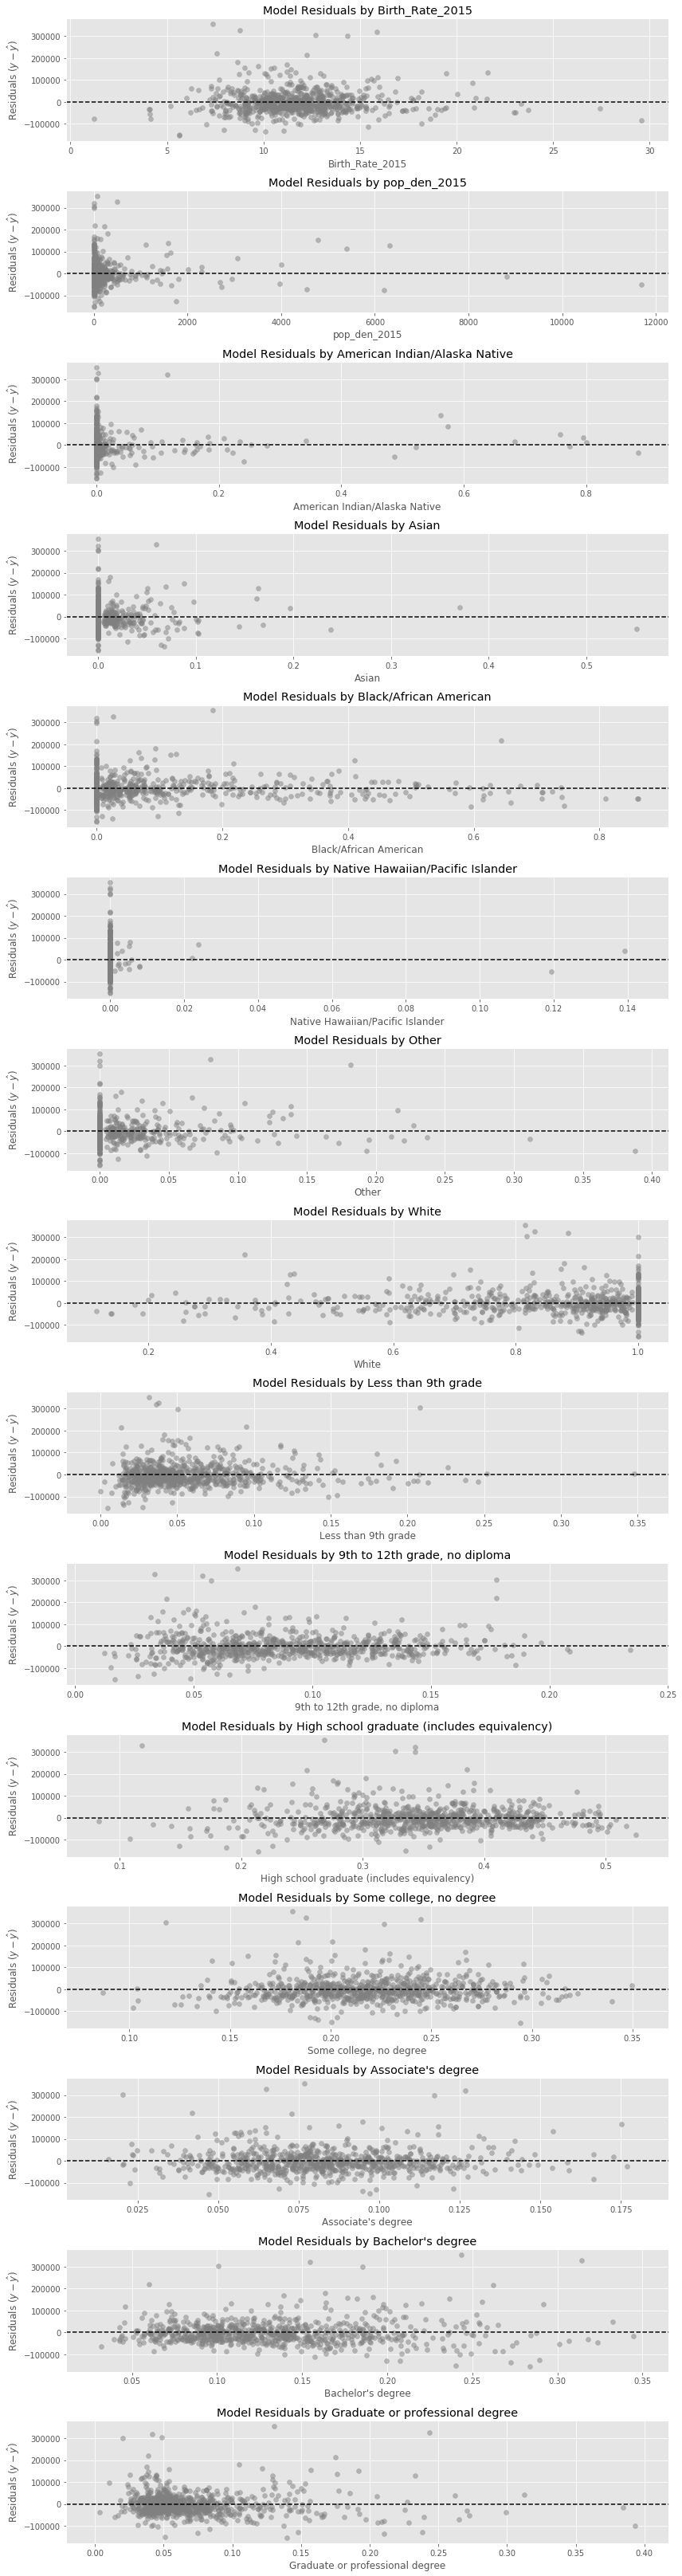

In [85]:
fig, axs = plot_many_residuals(X.columns, X_test_no_log, y_test_no_log, y_predict_no_log)
fig.tight_layout()


# Simple Linear vs Ridge for logged y vs Ridge for non-logged y

- ## Simple Linear predicting Log of Income disparity
    - Root Mean Squared Error = 0.2017 log dollars
    - Standard Deviation of Log Income Disparity = 0.2736 log dollars
    - Root Mean Squared Error relative to Standard Deviation = 0.7371
    - Coefficients are too large to be interpreted


- ## Ridge predicting Log of Income disparity
    - Root Mean Squared Error = 0.2015 log dollars
    - Standard Deviation of Log Income Disparity = 0.2736 log dollars
    - Root Mean Squared Error relative to Standard Deviation = 0.7364
    - Coefficients are small enough to be interpreted but they relate to the log of the target, which is difficult to translate directly back to impact on the target.
    
    
- ## Ridge predicting Income disparity
    - Root Mean Squared Error = 51,392 dollars
    - Standard Deviation of Log Income Disparity = 73,314 dollars
    - Root Mean Squared Error relative to Standard Deviation = 0.7010
    - Coefficients are small enough to be interpreted and they relate to the unlogged version of the target,which makes them easy to relate back to direct impact on the target. Only tricky thing is that the predictors are standardized so the coefficients need to be interpreted through that lens

# Interpreting Coefficients of the Ridge Model predicting Income disparity

In [82]:
ridge_no_log_coeff=ridge_no_log_coeff.sort_values('Name')
ridge_no_log_coeff['std_dev of predictor']=X_train_no_log.std().sort_index().values
ridge_no_log_coeff=ridge_no_log_coeff.sort_values('Coefficient')
ridge_no_log_coeff.round(3)

Name  Coefficient  \
10  High school graduate (includes equivalency)   -11119.813   
11                      Some college, no degree    -9671.813   
9                 9th to 12th grade, no diploma    -8680.260   
12                           Associate's degree    -3818.673   
8                           Less than 9th grade    -2610.460   
5              Native Hawaiian/Pacific Islander    -1703.608   
2                 American Indian/Alaska Native    -1612.523   
4                        Black/African American    -1229.811   
7                                         White     -245.773   
0                               Birth_Rate_2015     2436.882   
6                                         Other     4786.853   
3                                         Asian     6247.532   
1                                  pop_den_2015     6258.285   
14              Graduate or professional degree     8468.244   
13                            Bachelor's degree    24285.786   

    std_dev of predictor  Coef/stddev  
10                 0.071  -157300.455  
11                 0.039  -250615.271  
9                  0.037  -236830.151  
12                 0.025  -151630.494  
8                  0.038   -69242.707  
5                  0.005  -352174.933  
2                  0.079   -20437.167  
4                  0.148    -8295.863  
7                  0.170    -1441.866  
0                  2.677      910.316  
6                  0.037   129283.607  
3                  0.029   213943.877  
1               2048.342        3.055  
14                 0.040   214009.785  
13                 0.055   441142.145

# Hypothesis Testing

- Scientific Question: Do states with low population density (agg of lowest 5) have meaningfully different income gaps from states with high population density (agg of highest 5)?

- Hypothesis
    - H0: There is no difference in income inequality between low pop density states and high pop density states.
    - H1: There is a difference in income inequality between low pop density states and high pop density states.
    - alpha: 0.05
    - chosen test: two-sample t-test

In [92]:
# Create dataframe with state, county, info for population

state_target = merged_data.loc[:,['Diff Top5%-LowestQ', 'County_Code','State_Name','Pop_2015','pop_den_2015']]
state_target['area'] = state_target['Pop_2015']/state_target['pop_den_2015']

# Create a dataframe to figure out the pop density and pop density rank for each state
state_score = state_target.groupby('State_Name').sum().loc[:,['area','Pop_2015']]
state_score['state_pop_den'] = state_score['Pop_2015']/state_score['area']
state_score.sort_values('state_pop_den', inplace=True)
state_score['state_pop_rank'] = (np.arange(1,52))
state_score =  pd.DataFrame(state_score.to_records())

# Merge them
state_target = state_target.merge(state_score, how='left', on='State_Name')

# Add indicator for whether county is above or below median income gap
income_gap_median = predictors_target['Diff Top5%-LowestQ'].median()
state_target['gap_above_median'] = np.where(state_target['Diff Top5%-LowestQ']>income_gap_median,1,0)

### The most densely populated states are:
- Connecticut
- District of Columbia
- Massachusetts
- New Jersey
- Rhode Island

### The least densely populated states are
- Alaska
- Montana
- North Dakota
- South Dakota
- Wyoming


## T-test income disparity lowest vs highest pop density states

- Do not know that populations have equal variance so equal_var = False to perform Welch's ttest, which does not assume equal variance

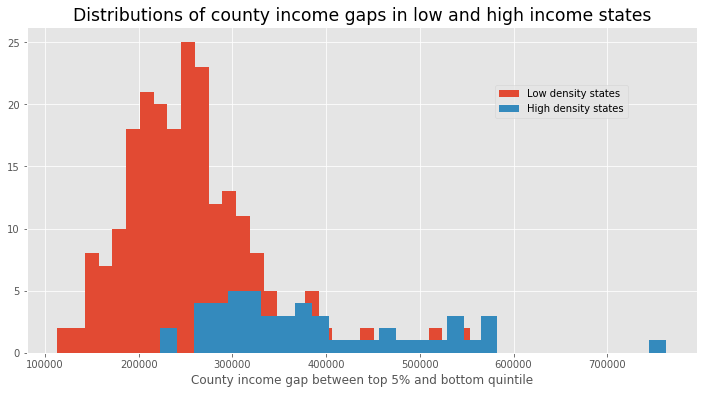

In [94]:
counties_5low_pop_den_states = state_target[state_target['state_pop_rank']<=5]
counties_5high_pop_den_states = state_target[state_target['state_pop_rank']>=47]

fig, ax = plt.subplots(1,figsize=(12,6))
ax.hist(counties_5low_pop_den_states['Diff Top5%-LowestQ'], label = 'Low density states', bins = 30 )
ax.hist(counties_5high_pop_den_states['Diff Top5%-LowestQ'], label = 'High density states', bins = 30)
fig.legend(loc=(.7,.7))
ax.set_title('Distributions of county income gaps in low and high income states', fontsize = 'xx-large')
ax.set_xlabel('County income gap between top 5% and bottom quintile');

In [90]:
test_statistic, p_value = stats.ttest_ind(counties_5high_pop_den_states['Diff Top5%-LowestQ'], \
                      counties_5low_pop_den_states['Diff Top5%-LowestQ'], equal_var = False)
print('The p_value for this test is {:.3}, which is below our selected alpha 0.05, so we can reject the null \
hypothesis that the mean income disparities of high population density states are the same as the mean \
income disparities of low population desity states'.format(p_value))

The p_value for this test is 3.25e-10, which is below our selected alpha 0.05, so we can reject the null hypothesis that the mean income disparities of high population density states are the same as the mean income disparities of low population desity states


# Further Investigation

- Bucket education and race into smaller buckets
- Are there other variables in the census dataset that better predict income inequality? Download the whole census dataset and do dimension reduction.